# Solving an inverse problem

In [5]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
import numpy as np
import torch
import tensorboard, datetime
import matplotlib.pyplot as plt
from torch import nn
%matplotlib inline

## PDE

$\frac{\partial^2 u}{\partial x^2} = f(x) \text{ for } x \in (0,1)$

$u(0) = u(1) = 0$

$f(x)$ is unknown, but we are given training samples $\{x_i,u_i\}$

## Training data

In [7]:
def u_true(x):
    return (1/48)*(8*x*(x**2 - 1) - (3/np.pi**2)*np.sin(4*np.pi*x))

Text(0, 0.5, 'y')

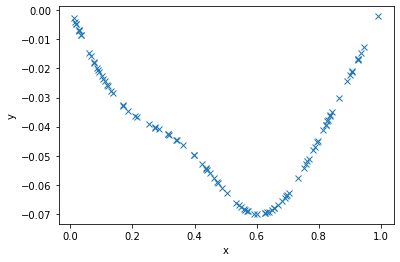

In [8]:
x_train = np.random.rand(100)
u_train = u_true(x_train)
plt.plot(x_train, u_train, 'x')
plt.xlabel('x')
plt.ylabel('y')

In [10]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 2)
        
    def forward(self, x):
        xt = x
        activation = nn.Tanh()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [ ]:
torch.manual_seed(23939)
model = ffnn(15, 2)

lr = 0.025
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 10000
loss_history = []

def loss(model, x, u_true): 
    output = model.forward(x)
    u = output[0] 
    f = output[1] 
    u_x = torch.autograd.grad(u, x, create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, retain_graph=True)[0]
    loss = torch.pow(u_xx-f, 2) + torch.pow(u-u_true, 2)
## Loss = MSE(u - u_i) + MSE(r_i)

## Task

Use a PINN to find $u(x)$ and $f(x)$